In [544]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from src.classes.ClassFractionalSin import FractionalSin
from tqdm import tqdm
import numpy as np
from scipy.stats import invgamma, multivariate_normal, poisson
from scipy.linalg import solve
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_fSinWithPosition_T256_H05_tl_5data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [545]:
config = get_config()

# Reversible jump MCMC for nonparametric drift estimation for diffusion processes (Van der Meulen et al 2013)

(1, 200001)


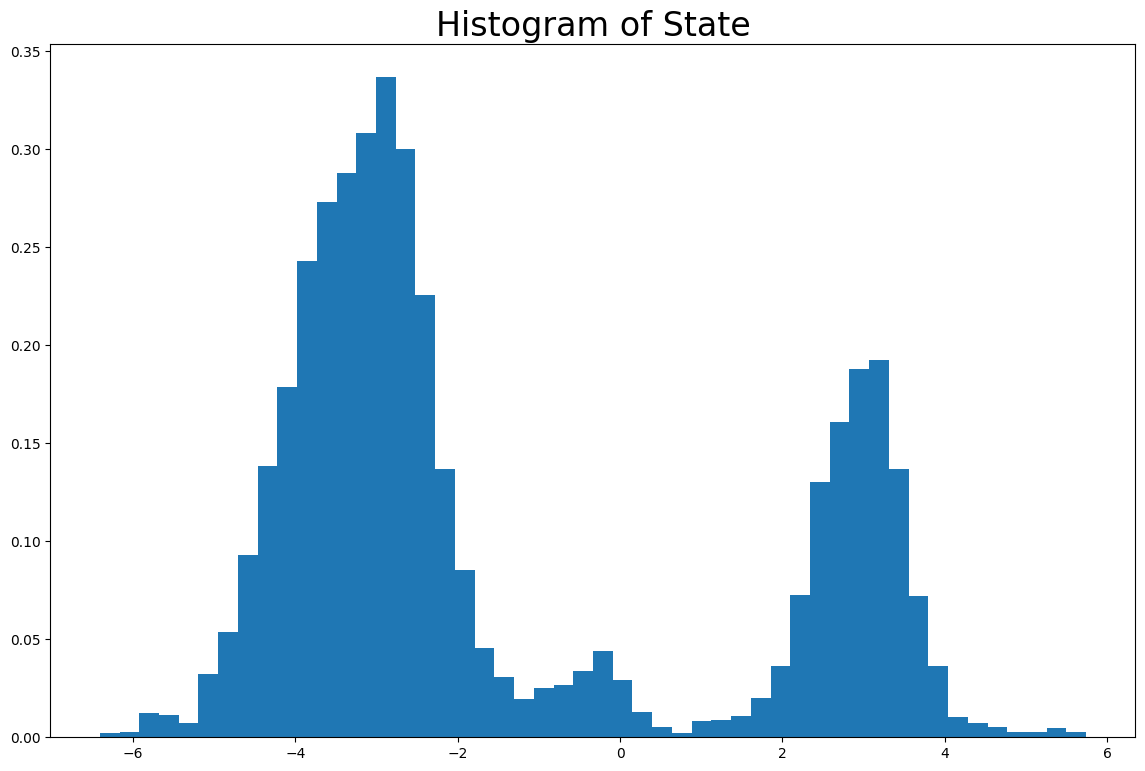

In [563]:
num_paths = 1
num_time_steps = int(200000)
isUnitInterval = True
mean_rev = config.mean_rev
diff = config.diffusion
initial_state = 0.
rvs = None
H = config.hurst
deltaT = 1./ (10**3)
t0 = 0.
t1 = deltaT*num_time_steps
space_scale = 1.
fSin = FractionalSin(mean_rev=mean_rev, diff=diff, X0=initial_state, space_scale=space_scale)
path = np.array(
    [fSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=0, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
    (num_paths, num_time_steps+1))
print(path.shape)
fig, ax = plt.subplots(figsize=(14,9))
plt.hist(path[0,1:], bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()

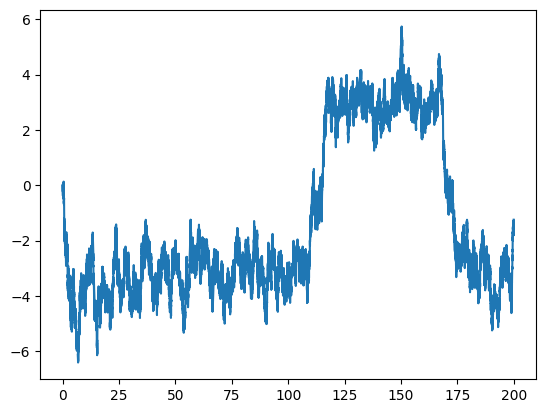

In [564]:
plt.plot(np.linspace(t0, t1, num_time_steps+1), path[0,:])

In [565]:
def get_level_2(idx):
    if 1<=idx<=2:
        return 0
    j = 1
    while True:
        eff_j = 2**j
        if eff_j + 1 <= idx <= 2*eff_j:
            return j
        j += 1
    raise RuntimeError("Invalid idx\n")

def faber_schauder_basis_2(R, path):
    """
    Compute Faber-Schauder basis functions up to level R for given x-values.
    """
    def faber_schauder(eff_j, k, x):
        assert (eff_j >= 1)
        assert (1 <= k <= eff_j)
        eff_x = eff_j * x - k + 1.
        if 0. <= eff_x < 0.5:
            return 2.*eff_x
        elif 0.5 <= eff_x <= 1.:
            return 2. * (1.- eff_x)
        else:
            return 0.
    # For \phi_1
    basis = []
    basis.append([faber_schauder(eff_j=1, k=1, x=x-0.5)+faber_schauder(eff_j=1, k=1, x=x+0.5) for x in path[0,:]])
    # For all other \phi_{j,k}
    for j in range(R + 1):  # Levels
        eff_j = int(2**j)
        for k in range(1,eff_j+1):  # Indices
            i = (2**j) + k
            assert (get_level_2(i) <= R)
            basis.append([faber_schauder(eff_j, k, x) for x in path[0,:]])
    basis = np.array(basis).T
    num_basis = int(2**(R+1))
    try:
        assert (basis.shape == (path.shape[1],num_basis))
    except AssertionError:
        print(f"Basis is wrong shape:{basis.shape, path.shape, num_basis}\n")
    return basis  # Each row is a basis function

def get_level(idx):
    if 1<=idx<=2:
        return 1
    j = 2
    while True:
        eff_j = 2**(j-1)
        if eff_j + 1 <= idx <= 2*eff_j:
            return j
        j += 1
    raise RuntimeError("Invalid idx\n")

def faber_schauder_basis(R, path):
    """
    Compute Faber-Schauder basis functions up to level R for given x-values.
    """
    def faber_schauder(eff_j, k, x):
        assert (eff_j >= 1)
        assert (1 <= k <= eff_j)
        eff_x = eff_j * x - k + 1.
        if 0. <= eff_x < 0.5:
            return 2.*eff_x
        elif 0.5 <= eff_x <= 1.:
            return 2. * (eff_x - 1.)
        else:
            return 0.
    # For \phi_1
    basis = []
    basis.append([1. for _ in path[0,:]])
    # For all other \phi_{j,k}
    for j in range(1, R):  # Levels
        eff_j = int(2**(j-1))
        for k in range(1,eff_j+1):  # Indices
            i = (2**(j-1)) + k
            assert (get_level(i) <= R)
            basis.append([faber_schauder(eff_j, k, x % 1) for x in path[0,:]])
    basis = np.array(basis).T
    num_basis = int(2**(R-1))
    try:
        assert (basis.shape == (path.shape[1],num_basis))
    except AssertionError:
        print(f"Basis is wrong shape:{basis.shape, path.shape, num_basis}\n")
    assert (path.shape[1] > num_basis), f"Level too large for amount of data: R={R}"
    return basis  # Each row is a basis function

def fourier_basis(R, path):
    """
    Compute Fourier basis functions up to level R for given x-values.
    """
    # Create an empty list for the basis functions
    basis = []
    # Construct Fourier Basis until level 2*R - 1
    basis.append([1. for _ in path[0,:]])
    max_x = np.max(np.abs(path[0,:])) + 1.
    for l in range(2, 2*R):
        # Compute the sine and cosine components
        if (l%2) == 0:
            k = int(l/2)
            assert np.isclose(2.*k - l, 0.)
            basis.append([np.sqrt(2.)*np.sin(2. * np.pi * k * (x/max_x)) for x in path[0, :]])
        else:
            k = int((l-1)/2)
            assert np.isclose(2.*k + 1 - l, 0.)
            basis.append([np.sqrt(2.)*np.cos(2. * np.pi * k * (x/max_x)) for x in path[0, :]])
    # Convert list to a numpy array, transpose to match shape (num_points, num_basis)
    basis = np.array(basis).T
    num_basis = 2 * R - 1
    try:
        assert basis.shape == (path.shape[1], num_basis)
    except AssertionError as e:
        print(f"Basis is wrong shape: {basis.shape}")
    return basis  # Each row is a basis function

def construct_drift(basis, Zs):
    drift = np.sum((basis * Zs.T), axis=1)[:, np.newaxis]
    assert (drift.shape[0] == basis.shape[0])
    return drift

In [567]:
def faber_schauder_regression(R, path, true_drift):
    # Deterministic regression under perfect observations of the drift
    # Our model is  b(Xti) = S\sum_{i}Z_{i}\phi_{i}
    # Thus we regress vector b = \phi(X)Z and find the vector Z which best matches it!
    basis = faber_schauder_basis(R=R, path=path[:, :-1])
    try:
        Z = (np.linalg.inv(basis.T@basis)@(basis.T@true_drift)).squeeze()
        print(f"Estimate of S2: {np.linalg.norm(Z)**2/np.sum([np.power(2,-float(get_level(i))) for i in range(1, basis.shape[1]+1)])}\n")
        drift = construct_drift(basis=basis, Zs=Z)
    except np.linalg.LinAlgError as e:
        drift = None
    return drift

def fourier_regression(R, path, true_drift):
    # Deterministic regression under perfect observations of the drift
    # Our model is  b(Xti) = S\sum_{i}Z_{i}\phi_{i}
    # Thus we regress vector b = \phi(X)Z and find the vector Z which best matches it!
    basis = fourier_basis(R=R, path=path[:, :-1])
    try:
        Z = (np.linalg.inv(basis.T@basis)@(basis.T@true_drift))#.squeeze()
        """try:
            print(f"Estimate of S2: {np.linalg.norm(Z)**2/np.sum([np.power(float(i),-1-2*1.5) for i in range(1, basis.shape[1]+1)])}\n")
        except IndexError as e:
            print(np.linalg.norm(Z)**2)"""
        drift = construct_drift(basis=basis, Zs=Z)
    except np.linalg.LinAlgError as e:
        drift = None
    return drift

def run_fourier_regression_model_selection(true_drift, path):
    fig, ax = plt.subplots(figsize=(14,9))
    plt.scatter(path[0,:-1], true_drift, label="True Drift")
    rmses = {}
    for R in tqdm(range(100, 104, 1)):#int((path.shape[1])/2.)+1, 1000)
        drift = fourier_regression(R=R, path=path, true_drift=true_drift)
        if drift is not None:
            rmses.update({R:np.linalg.norm(true_drift.flatten()-drift.flatten())/np.sqrt(drift.shape[0])})
        else:
            rmses.update({R:np.inf})
    rmses = dict(sorted(rmses.items(), key=lambda item: item[1]))
    print(rmses)
    for R in list(rmses.keys())[:1]:
        if rmses[R] is not np.inf:
            plt.scatter(path[0,:-1],fourier_regression(R=R, path=path, true_drift=true_drift), label=f"R={R}")
    plt.legend(fontsize=18)
    plt.title("Fourier Basis Regression for Perfectly Observed Drift", fontsize=24)
    ax.tick_params(labelsize=18)
    plt.show()
    plt.close()

def run_faber_schauder_regression_model_selection(true_drift, path):
    fig, ax = plt.subplots(figsize=(14,9))
    plt.scatter(path[0,:-1], true_drift, label="True Drift")
    rmses = {}
    for R in tqdm(range(1, int(np.log2(path.shape[1])))):
        drift = faber_schauder_regression(R=R, path=path, true_drift=true_drift)
        if drift is not None:
            rmses.update({R:np.linalg.norm(true_drift.flatten()-drift.flatten())})
        else:
            rmses.update({R:np.inf})
    rmses = dict(sorted(rmses.items(), key=lambda item: item[1]))
    for R in list(rmses.keys())[:3]:
        if rmses[R] is not np.inf:
            plt.scatter(path[0,:-1],faber_schauder_regression(R=R, path=path, true_drift=true_drift), label=f"R={R}")
    plt.legend(fontsize=18)
    plt.title("Faber Schauder Basis Regression for Perfectly Observed Drift", fontsize=24)
    ax.tick_params(labelsize=18)
    plt.show()
    plt.close()

true_drift = mean_rev * np.sin(space_scale * path[:,:-1]).T
#run_faber_schauder_regression_model_selection(true_drift=true_drift, path=path)
#run_fourier_regression_model_selection(true_drift=true_drift, path=path)

In [576]:
def sample_new_model(curr_model):
    if curr_model == 1:
        return int(np.random.choice([curr_model, curr_model+1], p=[0.9, 0.1]))
    return int(np.random.choice([curr_model, curr_model-1,curr_model+1], p=[0.9, 0.05, 0.05]))

def sample_prior_model(poisson_l, basis_type):
    """Y = poisson.rvs(mu=poisson_l)
    return int(np.floor(np.log2(Y)))"""
    assert (basis_type == "fourier")
    # Assume poisson_l is the "C" in the prior! And note that we need basis_type == "fourier"!
    u = np.random.random(size=1)
    return int(np.ceil(-0.5*np.log(1.-u)/poisson_l))

def sample_prior_scale(prior_a, prior_b):
    prior_scale = invgamma.rvs(a=prior_a, scale=prior_b, size=1)[0]
    assert isinstance(prior_scale, np.float64)
    return prior_scale

def construct_prior_cov_iid(num_basis, basis_type):
    if basis_type == "fs":
        # Note we have iid cov with standard deviation of each 2^-level/2
        prior_cov = np.diag(np.array([np.power(2, -float(get_level(i))) for i in range(1,num_basis+1)]))
    elif basis_type == "fourier":
        prior_cov = np.diag(np.array([np.power(float(i), -1-2*1.5) for i in range(1,num_basis+1)]))
    assert (prior_cov.shape == (num_basis, num_basis))
    return prior_cov

def sample_prior_Zs(prior_cov, S2):
    return multivariate_normal.rvs(mean=np.zeros((prior_cov.shape[0],)), cov=S2*prior_cov)[:, np.newaxis]

In [569]:
def sample_drift(R, Zs, path, basis_type):
    if basis_type == "fourier":
        basis = fourier_basis(R=R, path=path)
    elif basis_type == "fs":
        basis = faber_schauder_basis(R=R, path=path)
    assert basis.shape[1] == Zs.shape[0]
    return basis, construct_drift(basis=basis[:-1,:], Zs=Zs)

In [577]:
def initialise_from_priors(prior_a, prior_b, poisson_l, path, fixed_R, basis_type):
    if fixed_R is None:
        assert (poisson_l != 0.)
        R = sample_prior_model(poisson_l=poisson_l, basis_type=basis_type)
    else:
        assert (poisson_l == 0.)
        R = fixed_R
    S2 = sample_prior_scale(prior_a=prior_a, prior_b=prior_b)
    num_basis = int(2**(R-1)) if basis_type == "fs" else int(2*R - 1) #int(2**(R+1)) for _2 faber schauder
    prior_cov = construct_prior_cov_iid(num_basis=num_basis, basis_type=basis_type)
    assert (prior_cov.shape[0] == num_basis and prior_cov.shape[0] == prior_cov.shape[1])
    Zs = sample_prior_Zs(prior_cov=prior_cov, S2=S2)
    prior_basis, prior_drift = sample_drift(R=R, Zs=Zs, path=path, basis_type=basis_type)
    assert (prior_basis.shape[0] == prior_drift.shape[0] + 1 and prior_basis.shape[1] == num_basis)
    return R, S2, prior_cov, Zs, prior_basis, prior_drift

In [578]:
def sample_posterior_scale(prior_shape, prior_scale, ll_shape, Zs, prior_cov):
    assert (len(Zs.shape) == len(prior_cov.shape) and len(prior_cov.shape) == 2)
    assert (Zs.shape[0] == prior_cov.shape[0] and Zs.shape[1] == 1)
    assert (ll_shape == prior_cov.shape[0])
    z = np.linalg.solve(prior_cov, Zs)
    assert (z.shape == Zs.shape)
    ll_scale = (Zs.T@z)[0,0]
    assert isinstance(ll_scale, np.float64)
    new_scale = invgamma.rvs(a=prior_shape+0.5*ll_shape, scale=prior_scale+0.5*ll_scale, size=1)[0]
    assert isinstance(new_scale, np.float64)
    return new_scale

def construct_posterior_precision(prior_cov, basis, S2, Delta):
    # TODO: Linear interpolation for the path?
    # TODO: Note we multiply each Z with S, hence we multiply the prior by S^2!
    assert (prior_cov.shape[0] == basis.shape[1])
    Gamma = np.power(S2,-1.)*np.linalg.inv(prior_cov) # TODO: More efficient
    G = basis[:-1,:].T @ basis[:-1,:] * Delta
    W = G + Gamma
    try:
        assert np.all(np.linalg.eigvalsh(W) > 0.)
    except AssertionError as e:
        raise AssertionError(e)
    return W

def construct_posterior_mu(basis, path):
    # TODO: Linear interpolation for path?
    assert (basis.shape[0] == path.shape[1])
    mu = np.sum(basis[:-1,:].T@np.diff(path,axis=1).T,axis=1)[:, np.newaxis]
    assert (mu.shape == (basis.shape[1], 1))
    return mu

def compute_rao_post_mean(precision, mu):
    assert (precision.shape[0] == mu.shape[0] and len(mu.shape)==2)
    cov =  np.linalg.inv(precision)
    return cov@mu

def sample_posterior_Zs(mu, model_precision):
    assert (len(mu.shape) == 2)
    """U_P = np.linalg.cholesky(model_precision).T # Upper triangular cholesky U_P = L_P.T
    y = np.linalg.solve(U_P, mu) # Solve (L_P)^T y = mu
    z = np.random.randn(U_P.shape[0],1)
    k = np.atleast_2d(np.linalg.solve(U_P.T, y+z)) # Solve L_P k = y + z"""
    model_cov = np.linalg.inv(model_precision)
    try:
        mean = model_cov@mu
    except ValueError:
        print("Sample Zs error,",model_precision, model_cov, mu)
    k = np.atleast_2d(multivariate_normal.rvs(mean=mean.flatten(), cov=model_cov)).T
    assert (k.shape[1] == 1 and k.shape[0] == model_precision.shape[0])
    return k

def compute_acceptance_probability(poisson_l, new_model, curr_model, S2, new_precision, new_prior_cov, new_mu, basis_type):
    new_num_basis = int(2**(new_model + 1)) if basis_type == "fs" else int(2*new_model - 1)
    old_num_basis = int(2**(curr_model + 1)) if basis_type == "fs" else int(2*new_model - 1)
    assert (new_precision.shape[0] == new_mu.shape[0] and new_mu.shape[0] == new_num_basis)
    if new_model == 1 or curr_model == 1 and new_model != curr_model:
        factor = -1 if new_model > curr_model else 1
        log_transition_pmf = factor*(np.log(0.05) - np.log(0.1)) # np.log(x) - np.log(2x) where x is prob of new != old
    else:
        log_transition_pmf = 0.
    """new_model_log_pmf = np.log(np.sum([poisson.pmf(k=k, mu=poisson_l) for k in np.arange(np.ceil(2**new_model), np.floor(2**(new_model+1))+1)]))
    old_model_log_pmf = np.log(np.sum([poisson.pmf(k=k, mu=poisson_l) for k in np.arange(np.ceil(2**curr_model), np.floor(2**(curr_model+1))+1)]))"""
    assert (basis_type == "fourier") # We need this for the log_pmf below to be valid!
    new_model_log_pmf = -poisson_l*new_model
    old_model_log_pmf = -poisson_l*curr_model
    if new_model == curr_model:
        log_bayes = 0.
    else:
        M = np.linalg.cholesky(new_precision).T
        z = solve(M, new_mu)
        g = z[old_num_basis:]
        # TODO: I assume diagonal entries of new_prior_cov are the squared epsilons
        epsilons = np.sqrt(np.diag(new_prior_cov))
        assert (len(epsilons.shape)==1)
        log_bayes = 0.5*((np.linalg.norm(g)**2)-2*np.sum([np.log(np.sqrt(S2)*M[mj, mj]*epsilons[mj]) for mj in range(old_num_basis, new_num_basis)]))
    log_accp = log_bayes + new_model_log_pmf - old_model_log_pmf + log_transition_pmf
    if log_accp > 0:
        return 1.
    return np.exp(log_accp)

In [579]:
def sample_brownian_bridge(start_time, end_time, start_pos, end_pos, num_points, Delta):
    assert (np.abs(end_time-start_time - Delta) < 1e-12)
    time_steps = np.linspace(0, Delta, num=num_points+1)/Delta
    noise = np.sqrt(Delta/float(num_points))*np.random.normal(size=num_points)
    noise = np.insert(noise, [0], 0)
    brownian_motion = np.cumsum(noise)
    brownian_bridge = start_pos + time_steps*(end_pos - start_pos) + brownian_motion - (brownian_motion[-1])*time_steps
    assert ((brownian_bridge[0] == start_pos) and brownian_bridge.shape[0] == num_points + 1)
    return brownian_bridge[1:]

def linear_interpolation(start_time, end_time, start_pos, end_pos, num_points, Delta):
    assert (np.abs(end_time-start_time - Delta) < 1e-12)
    time_steps = np.linspace(0, Delta, num=num_points+1)/Delta
    interpol = start_pos + (end_pos - start_pos)*(time_steps - start_time)/Delta
    return interpol[1:]

def compute_log_likelihood(dt, path, drift):
    assert (len(path.shape)==1)
    dX = np.diff(path)
    return np.sum(drift*dX - 0.5*np.power(drift,2)*dt)

def compute_bridge_acceptance_probability(wk, xk, dt, R, Zs, basis_type):
    l1 = compute_log_likelihood(dt=dt, path=wk, drift=sample_drift(R=R, Zs=Zs, path=wk[np.newaxis,:], basis_type=basis_type)[1])
    l2 = compute_log_likelihood(dt=dt, path=xk, drift=sample_drift(R=R, Zs=Zs, path=xk[np.newaxis,:], basis_type=basis_type)[1])
    if l1 - l2 > 0:
        return 1.
    return np.exp(l1-l2)


In [587]:
def reversible_jump_basis(path, basis_type, deltaT):
    prior_a = 5.
    prior_b = 5.
    poisson_l = -np.log(0.95)#10.
    R, S2, prior_cov, Zs, basis, prior_drift = initialise_from_priors(prior_a=prior_a, prior_b=prior_b, poisson_l=poisson_l, path=path, fixed_R=None, basis_type=basis_type)
    # Data augmentation for low(er)-frequency observations
    #num_bb_points = 49
    #time_ax = np.linspace(t0,t1,num_time_steps+1)
    #assert (time_ax.shape[0] == path.shape[1])
    #xks = [linear_interpolation(start_time=time_ax[k], end_time=time_ax[k+1], start_pos=0 if k==0 else path[0,k-1], end_pos=path[0,k], num_points=num_bb_points, Delta=deltaT) for k in range(path.shape[1])]
    # Main code
    # TODO: Check this is correct
    model_precision = construct_posterior_precision(prior_cov=prior_cov, basis=basis, S2=S2, Delta=deltaT)
    mu = construct_posterior_mu(basis=basis, path=path)
    Ss = [S2]
    Rs = [R]
    ZZs = [Zs]
    rao_means = [compute_rao_post_mean(precision=model_precision, mu=mu)]
    for _ in tqdm(range(3000)):
        # Note that prior_cov is always diagonal
        num_basis = int(2**(R-1)) if basis_type == "fs" else int(2*R - 1) # int(2**(R-1)) if _2 faber_schauder
        S2 = sample_posterior_scale(prior_shape=prior_a, prior_scale=prior_b, ll_shape=num_basis, Zs=Zs, prior_cov=prior_cov)
        Ss.append(S2)
        new_model = sample_new_model(R)
        assert (new_model > 0)
        if new_model != R:
            new_basis = faber_schauder_basis(R=new_model, path=path) if basis_type == "fs" else fourier_basis(R=new_model, path=path)
            new_num_basis = int(2**(new_model-1)) if basis_type == "fs" else int(2*new_model - 1)
            new_prior_cov = construct_prior_cov_iid(num_basis=new_num_basis, basis_type=basis_type)
            new_model_precision = construct_posterior_precision(prior_cov=new_prior_cov, basis=new_basis, S2=S2, Delta=deltaT) # new_S?
            new_mu = construct_posterior_mu(basis=new_basis, path=path)
            new_Zs = sample_posterior_Zs(mu=new_mu, model_precision=new_model_precision)
            # TODO: If new_model < curr_model, we need to flip around when calculating the acceptance probability
            if new_model >= R:
                p = compute_acceptance_probability(poisson_l=poisson_l, new_model=new_model, curr_model=R, S2=S2, new_precision=new_model_precision, new_mu=new_mu, new_prior_cov=new_prior_cov, basis_type=basis_type)
            else:
                mu = construct_posterior_mu(basis=basis, path=path)
                p = compute_acceptance_probability(poisson_l=poisson_l, new_model=R, curr_model=new_model, S2=S2, new_precision=model_precision, new_mu=mu, new_prior_cov=prior_cov, basis_type=basis_type)
            u = np.random.uniform() <= p
            R = new_model if u else R
            Zs = new_Zs if u else Zs
            prior_cov = new_prior_cov if u else prior_cov
            model_precision = new_model_precision if u else model_precision
            basis = new_basis if u else basis
            mu = new_mu if u else mu
        Rs.append(R)
        # Data augmentation for low(er)-frequency data
        for k in range(0):
            # TODO: Why is this needed?
            wk = sample_brownian_bridge(start_time=time_ax[k], end_time=time_ax[k+1], start_pos=0 if k==0 else path[0,k-1], end_pos=path[0,k], num_points=num_bb_points, Delta=deltaT)
            rk = compute_bridge_acceptance_probability(wk=wk, xk=xks[k], R=R, Zs=Zs, dt = deltaT/num_bb_points, basis_type=basis_type)
            u = np.random.uniform() <= rk
            xks[k] = wk if u else xks[k]
        ZZs.append(Zs)
        rao_means.append(compute_rao_post_mean(precision=model_precision, mu=mu))
    return Ss, Rs, ZZs, rao_means

def fixed_model_basis(path, fixed_R, basis_type, deltaT):
    prior_a = 2.5
    prior_b = 2.5
    r, S2, prior_cov, Zs, basis, prior_drift = initialise_from_priors(prior_a=prior_a, prior_b=prior_b, poisson_l=0., path=path, fixed_R=fixed_R, basis_type=basis_type)
    assert (r == fixed_R)
    Ss = [S2]
    mu = construct_posterior_mu(basis=basis, path=path)
    model_precision = construct_posterior_precision(prior_cov=prior_cov, basis=basis, S2=S2, Delta=deltaT)
    ZZs = [Zs]
    rao_means = [compute_rao_post_mean(precision=model_precision, mu=mu)]
    num_basis = int(2**(fixed_R-1)) if basis_type == "fs" else int(2*fixed_R - 1) # int(2**(R-1)) if _2 faber_schauder
    for _ in tqdm(range(1000)):
        # Note that prior_cov is always diagonal
        S2 = sample_posterior_scale(prior_shape=prior_a, prior_scale=prior_b, ll_shape=num_basis, Zs=Zs, prior_cov=prior_cov)
        Ss.append(S2)
        model_precision = construct_posterior_precision(prior_cov=prior_cov, basis=basis, S2=S2, Delta=deltaT) # new_S?
        Zs = sample_posterior_Zs(mu=mu, model_precision=model_precision)
        ZZs.append(Zs)
        rao_means.append(compute_rao_post_mean(precision=model_precision, mu=mu))
    return Ss, [fixed_R for _ in Ss], ZZs, rao_means

fixed_R = 2
basis_type = "fourier"
Ss, Rs, ZZs, rao_means = reversible_jump_basis(path=path, basis_type=basis_type, deltaT=deltaT)

100%|██████████| 3000/3000 [1:10:03<00:00,  1.40s/it]


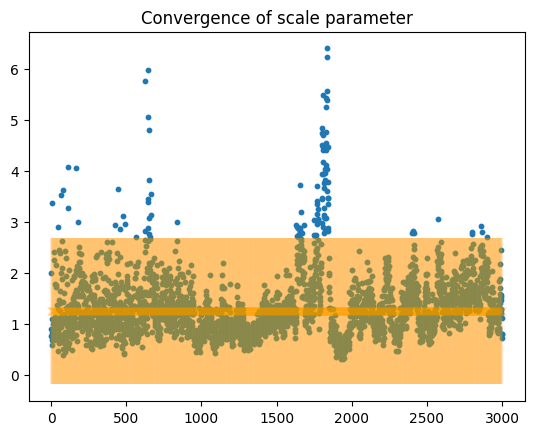

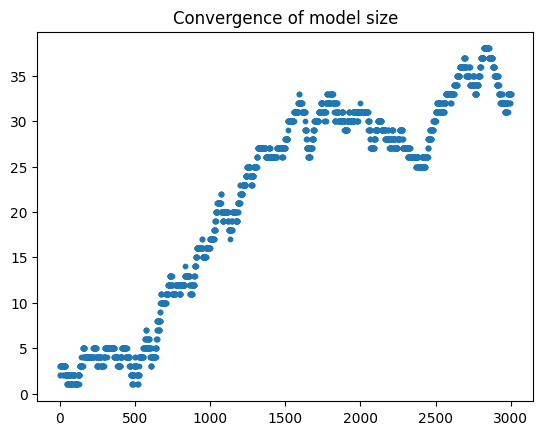

In [588]:
plt.scatter(np.arange(len(Ss)), Ss, s=10)
plt.errorbar(x=np.arange(len(Ss)), y=[5./(5.-1.)]*len(Ss), yerr=2*np.sqrt(5.**2/((5.-1)**2*(5.-2))), alpha=0.05, fmt="x",label="Est", color="orange")
plt.title("Convergence of scale parameter")
plt.show()
plt.close()
plt.scatter(np.arange(len(Rs)), Rs, s=10)
plt.title("Convergence of model size")
plt.show()
plt.close()

In [591]:
ddrifts = []
rao_ddrifts = []
for k in tqdm(range(len(Ss)-50, len(Ss))):
    Zs = ZZs[k]
    R = Rs[k]
    rao_Zs = rao_means[k]
    ddrifts.append(sample_drift(R=R, path=path, Zs=Zs, basis_type=basis_type)[1])
    rao_ddrifts.append(sample_drift(R=R, path=path, Zs=rao_Zs, basis_type=basis_type)[1])
mabes = np.array(ddrifts)[:,:,0]
mean = mabes.mean(axis=0)
std = mabes.std(axis=0)
plt.scatter(path[0,:-1], mean_rev*np.sin(space_scale*path[0,:-1]), label="True")
plt.errorbar(x=path[0,:-1], y=mean, yerr=0*std, alpha=0.5, fmt="x",label="Est", color="orange")
plt.legend()
plt.show()
plt.close()

 10%|█         | 5/50 [04:32<40:54, 54.55s/it]


KeyboardInterrupt: 

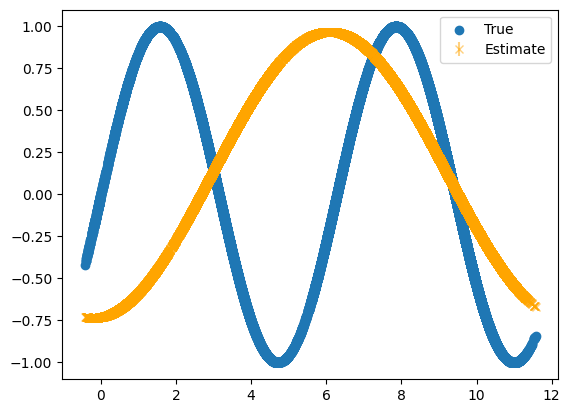

In [562]:
mabes = np.array(rao_ddrifts)[:,:,0]
mean = mabes.mean(axis=0)
std = mabes.std(axis=0)
plt.scatter(path[0,:-1], mean_rev*np.sin(space_scale*path[0,:-1]), label="True")
plt.errorbar(x=path[0,:-1], y=mabes.flatten(), yerr=0, alpha=0.5, fmt="x",label="Estimate", color="orange")
plt.legend()
plt.show()
plt.close()